<a href="https://www.kaggle.com/code/arnavmishra6996/s4e9-xgboost-optuna-optimization?scriptVersionId=195200952" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


# Overview of XGBoost

**XGBoost** (Extreme Gradient Boosting) is a powerful machine learning algorithm based on the gradient boosting framework. It's widely used for structured (tabular) data and has consistently performed well in machine learning competitions like Kaggle. XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable.

## Why Use XGBoost?

### Efficiency and Speed

- **Parallel Processing**: XGBoost can perform parallel processing on a single machine. Most implementations of boosting are sequential, but XGBoost optimizes it for speed by using multithreading.
- **Handling of Missing Values**: XGBoost can handle missing data internally, saving time on data preprocessing.
- **Sparse Aware**: XGBoost can handle sparse data efficiently, which is common in large datasets with many missing values or when features are encoded as one-hot vectors.

### Accuracy

- **Regularization**: XGBoost includes regularization (L1 and L2), which helps prevent overfitting, leading to better generalization.
- **Pruning**: During tree construction, XGBoost employs a "max_depth" parameter to prune the tree and prevent it from growing too complex.
- **Weighted Quantile Sketch**: This allows the algorithm to approximate the distribution of features, making it possible to handle large-scale data with high accuracy.

### Flexibility

- **Custom Objectives and Evaluation Metrics**: You can define custom loss functions and evaluation metrics, making XGBoost highly adaptable to different problem types.
- **Tree Pruning (Depth-wise Pruning)**: Instead of growing trees greedily, XGBoost prunes them as soon as it realizes that further splits don't improve the model.

## Mathematical Formulation of XGBoost

XGBoost builds an ensemble of decision trees, and each tree is trained to minimize the errors of the previous trees. Here's how it works mathematically:

### 1. Objective Function

The objective function in XGBoost consists of two parts:

- **Training Loss**: This measures how well the model fits the training data (e.g., mean squared error for regression).
- **Regularization Term**: This penalizes the complexity of the model to prevent overfitting.

The objective function for a given tree \( t \) can be expressed as:

$$
\text{Obj}(\theta) = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t)}) + \sum_{k=1}^T \Omega(f_k)
$$

Where:

- \( \theta \) represents the parameters of the model (e.g., tree structure and leaf weights).
- \( l(y_i, \hat{y}_i^{(t)}) \) is the loss function (e.g., squared error for regression or logistic loss for classification).
- \( \Omega(f_k) = \gamma T + \frac{1}{2} \lambda \sum_{j=1}^{T} w_j^2 \) is the regularization term where \( T \) is the number of leaves, \( w_j \) are the leaf weights, and \( \gamma \) and \( \lambda \) are regularization parameters.

### 2. Additive Training

XGBoost builds the model in an additive fashion, where it minimizes the objective function by adding one tree at a time:

$$
\hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + f_t(x_i)
$$

Here, \( f_t(x_i) \) is the function (tree) that we add to the model at step \( t \), and \( \hat{y}_i^{(t)} \) is the prediction at step \( t \).

### 3. Taylor Expansion for Loss Function

To optimize the objective function, XGBoost uses a second-order Taylor expansion of the loss function:

$$
\text{Obj}^{(t)} = \sum_{i=1}^n \left[ g_i f_t(x_i) + \frac{1}{2} h_i f_t(x_i)^2 \right] + \Omega(f_t)
$$

Where:

- \( g_i = \partial_{\hat{y}^{(t-1)}} l(y_i, \hat{y}^{(t-1)}) \) is the first-order derivative (gradient) of the loss with respect to the prediction.
- \( h_i = \partial_{\hat{y}^{(t-1)}}^2 l(y_i, \hat{y}^{(t-1)}) \) is the second-order derivative (Hessian) of the loss with respect to the prediction.

The use of both first and second derivatives helps in better approximating the loss and improving convergence.

### 4. Tree Structure and Split Finding

For each candidate split, XGBoost calculates the gain in the objective function. The gain is defined as:

$$
\text{Gain} = \frac{1}{2} \left[ \frac{G_L^2}{H_L + \lambda} + \frac{G_R^2}{H_R + \lambda} - \frac{(G_L + G_R)^2}{H_L + H_R + \lambda} \right] - \gamma
$$

Where:

- \( G_L, H_L \) are the sums of the gradients and Hessians for the left child.
- \( G_R, H_R \) are the sums of the gradients and Hessians for the right child.
- \( \lambda \) is the regularization term for leaf weights.
- \( \gamma \) is the complexity cost by introducing a new leaf node.

XGBoost selects the split that maximizes this gain, leading to a tree structure that best fits the data while controlling complexity.

## Conclusion

XGBoost is a robust, efficient, and flexible tool for machine learning, particularly when working with structured datasets. Its combination of accuracy, speed, and the ability to handle large-scale data makes it an essential tool in the data scientist's toolkit.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder


In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
sub = pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')
id = test['id']

In [4]:
train

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,Escalade ESV Platinum,2017,49000,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,None reported,Yes,27500
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,30000
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,None reported,Yes,86900
188531,188531,Audi,S5 3.0T Prestige,2022,13895,Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,None reported,NaN,84900


# Data Cleaning 

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [6]:
train.isnull().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [7]:
missing_percentage = train.isnull().mean() * 100
print(missing_percentage[missing_percentage > 0])


fuel_type       2.696080
accident        1.300568
clean_title    11.360876
dtype: float64


**We see here that the missing percentage are as follows:**
- fuel_type    =   2.696080
- accident     =  1.300568
- clean_title  =  11.360876

For fuel_type and accident , let's replace the values with the mode

In [8]:
train.clean_title.unique()

array(['Yes', nan], dtype=object)

In [9]:
train.isna().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [10]:
train.fuel_type.unique()

array(['Gasoline', 'E85 Flex Fuel', nan, 'Hybrid', 'Diesel',
       'Plug-In Hybrid', '–', 'not supported'], dtype=object)

In [11]:
train['clean_title'].fillna('Yes', inplace=True)

/tmp/ipykernel_22/2207802353.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['clean_title'].fillna('Yes', inplace=True)


In [12]:
train

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,Escalade ESV Platinum,2017,49000,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,None reported,Yes,27500
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,30000
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,None reported,Yes,86900
188531,188531,Audi,S5 3.0T Prestige,2022,13895,Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,None reported,Yes,84900


In [13]:
categorical_columns = train.select_dtypes(include=['object']).columns

for column in categorical_columns:
    if train[column].dtype == 'object':  
        mode_value = train[column].mode()[0]
        train[column].fillna(mode_value, inplace=True) 

/tmp/ipykernel_22/2032938395.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[column].fillna(mode_value, inplace=True)


# Label Encoder

In [14]:
label_encoder = LabelEncoder()
for column in categorical_columns:
    if train[column].dtype == 'object': 
        train[column] = label_encoder.fit_transform(train[column])

In [15]:
categorical_columns = test.select_dtypes(include=['object']).columns
for column in categorical_columns:
    test[column] = label_encoder.fit_transform(test[column])


# EDA 

                    id     brand     model  model_year    milage  fuel_type  \
id            1.000000 -0.000315  0.000184    0.000076 -0.001834   0.002263   
brand        -0.000315  1.000000 -0.040049   -0.014605 -0.007286   0.043534   
model         0.000184 -0.040049  1.000000    0.001784  0.041706   0.009617   
model_year    0.000076 -0.014605  0.001784    1.000000 -0.669936   0.010908   
milage       -0.001834 -0.007286  0.041706   -0.669936  1.000000  -0.105261   
fuel_type     0.002263  0.043534  0.009617    0.010908 -0.105261   1.000000   
engine        0.001962 -0.065512 -0.042079    0.285300 -0.331196   0.020990   
transmission -0.001382  0.036984 -0.027031    0.043596 -0.041158   0.093713   
ext_col      -0.002020  0.006038  0.007560   -0.032189  0.027763  -0.010751   
int_col       0.003013 -0.004765  0.076990    0.024833 -0.030846   0.004114   
accident      0.000433  0.005564 -0.017556    0.256367 -0.321356   0.036566   
clean_title        NaN       NaN       NaN         N

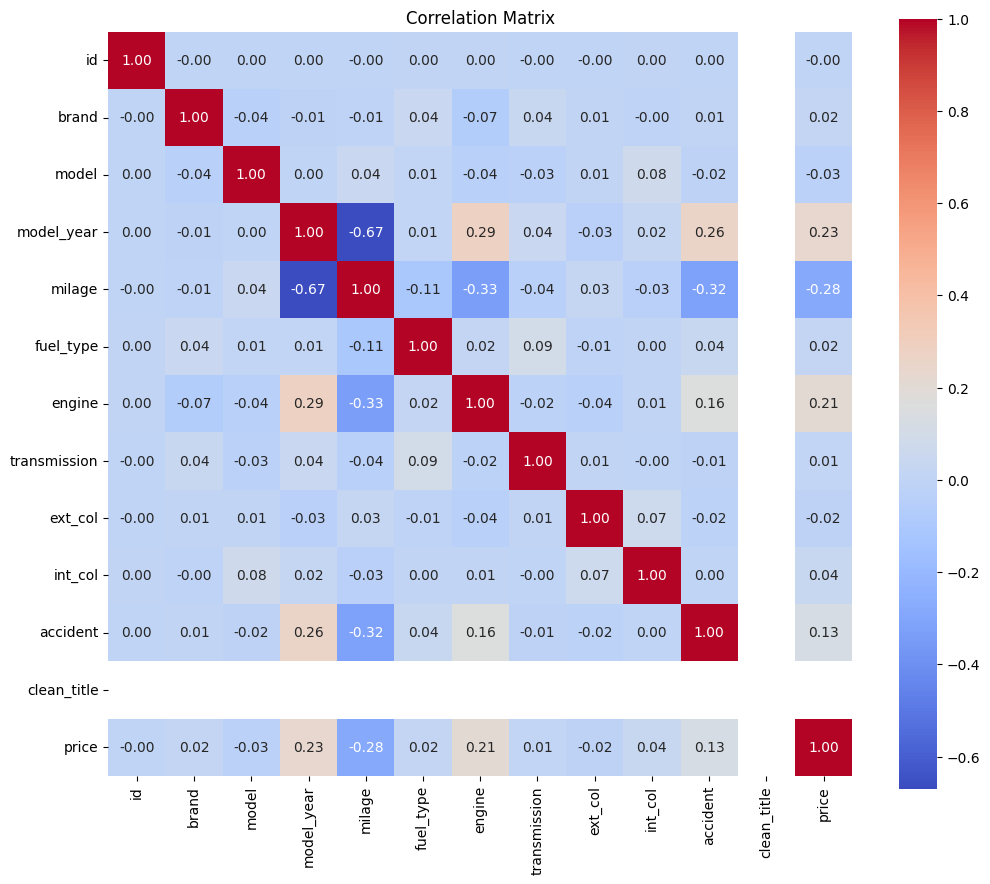

In [16]:
correlation_matrix = train.corr(numeric_only=True)

# Print the correlation matrix
print(correlation_matrix)

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [17]:
features = ['model_year', 'milage', 'engine', 'accident']
x = train[features]
y = train['price']
test = test[features]


In [18]:
x

,model_year,milage,engine,accident
0,2007,213000,116,1
1,2002,143250,366,0
2,2002,136731,640,1
3,2017,19500,863,1
4,2021,7388,259,1
...,...,...,...,...
188528,2017,49000,866,1
188529,2018,28600,770,0
188530,2021,13650,921,1
188531,2022,13895,512,1


# Optuma Optimzation 

In [19]:
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)


In [20]:
def objective(trial):
    # Define hyperparameters to tune
    param = {
        'objective': 'reg:squarederror',  # Regression task
        'eval_metric': 'rmse',  # Metric for evaluation
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_uniform('gamma', 0, 5),
        'lambda': trial.suggest_uniform('lambda', 0, 5)
    }

    # Create and train the XGBoost model
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = model.predict(X_val)
    
    # Calculate RMSE
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    return rmse


In [21]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50) 


[I 2024-09-03 18:37:50,854] A new study created in memory with name: no-name-2e130d3d-4023-4821-b671-0c22199b952b
/tmp/ipykernel_22/2725634547.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
/tmp/ipykernel_22/2725634547.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_22/2725634547.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5

In [22]:
print("Best hyperparameters:", study.best_params)
print("Best RMSE:", study.best_value)

Best hyperparameters: {'n_estimators': 600, 'max_depth': 5, 'learning_rate': 0.01449048404237471, 'subsample': 0.8924477295546205, 'colsample_bytree': 0.6716676968969558, 'gamma': 2.6207593736816297, 'lambda': 4.235710961367866}
Best RMSE: 68383.1988767592


# Model training 

In [23]:
best_params = study.best_params
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(x, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6716676968969558, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=2.6207593736816297,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=4.235710961367866,
             learning_rate=0.01449048404237471, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, ...)

In [24]:
test

,model_year,milage,engine,accident
0,2015,98000,326,1
1,2020,9142,787,1
2,2022,28121,541,1
3,2016,61258,193,1
4,2018,59000,365,1
...,...,...,...,...
125685,2014,83315,732,1
125686,2019,29336,511,1
125687,2012,77634,673,1
125688,2012,112000,673,1


In [25]:
pred = final_model.predict(test)

In [26]:
submission = pd.DataFrame({
    'id': id,
    'pred': pred
})


In [27]:
submission.to_csv('submission.csv', index=False)